### Constants

In [15]:
DEPARTURE = 'LEMD'
DESTINATION = 'LEBL'

FLIGHTS_PATH = 'data/flights'
FLIGHTS_POINTS_PATH = 'data/flight_points'

METHOD = 'silhouette'
GRAPHS_PATH = f'results/graphs/single-trajectory/{METHOD}'

In [2]:
from src.pipeline import build_pipeline

data_pipeline = build_pipeline(flights_path = FLIGHTS_PATH, 
                               flights_points_path = FLIGHTS_POINTS_PATH, 
                               departure = DEPARTURE, 
                               destinations = [DESTINATION])

trajectories_result, sspd_calculator, erp_calculator = data_pipeline.transform(None)

trajectories = trajectories_result['trajectories']
sspd_distances = sspd_calculator['sspd_distances']
erp_distances = erp_calculator['erp_distances']

## SSPD distances

### DBSCAN

In order to determine the best value of eps for your dataset, use the K-Nearest Neighbours approach as explained in these two papers: [Sander et al. 1998](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.63.1629&rep=rep1&type=pdf) and [Schubert et al. 2017](https://www.ccs.neu.edu/home/vip/teach/DMcourse/2_cluster_EM_mixt/notes_slides/revisitofrevisitDBSCAN.pdf) (both papers from the original DBSCAN authors).

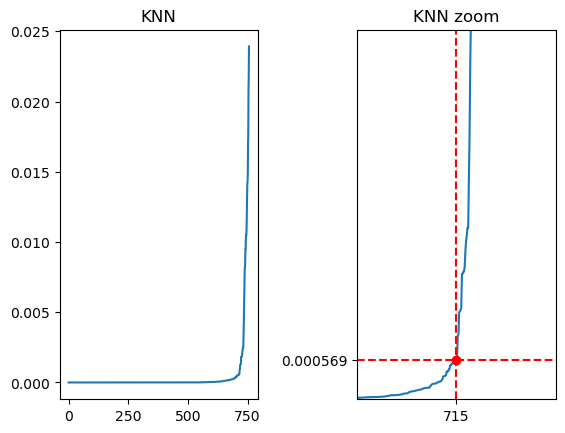

In [17]:
from utils.graphs import show_elbow_plot
from sklearn.neighbors import NearestNeighbors
import numpy as np

neighbors = NearestNeighbors(n_neighbors=6, metric='precomputed')
neighbors_fit = neighbors.fit(sspd_distances)
distances, indices = neighbors_fit.kneighbors(sspd_distances)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

line = np.linspace(distances[0], distances[-1], len(distances))
distances_to_line = np.abs(distances - line)
elbow_index = np.argmax(distances_to_line)

show_elbow_plot(distances, elbow_index, f'{GRAPHS_PATH}/elbow_sspd.png')

In [18]:
import numpy as np
import pandas as pd
from src.models.search_dbscan import SearchDBSCAN

search = SearchDBSCAN(sspd_distances, params = {
  "eps": np.array([distances[elbow_index]]),
  "min_samples": np.arange(2, 16)
}, method=METHOD)

print(pd.DataFrame(search["results_"]).head(20))

                                               params  clusters  outliers   
0    {'eps': 0.0005686400727954557, 'min_samples': 3}         9        55  \
1    {'eps': 0.0005686400727954557, 'min_samples': 4}         8        58   
2    {'eps': 0.0005686400727954557, 'min_samples': 5}         9        58   
3    {'eps': 0.0005686400727954557, 'min_samples': 2}        16        41   
4    {'eps': 0.0005686400727954557, 'min_samples': 6}         8        63   
5    {'eps': 0.0005686400727954557, 'min_samples': 9}         9        77   
6   {'eps': 0.0005686400727954557, 'min_samples': 10}         9        78   
7    {'eps': 0.0005686400727954557, 'min_samples': 7}         9        69   
8   {'eps': 0.0005686400727954557, 'min_samples': 11}         7       103   
9    {'eps': 0.0005686400727954557, 'min_samples': 8}         8        76   
10  {'eps': 0.0005686400727954557, 'min_samples': 12}         7       105   
11  {'eps': 0.0005686400727954557, 'min_samples': 13}         7       105   

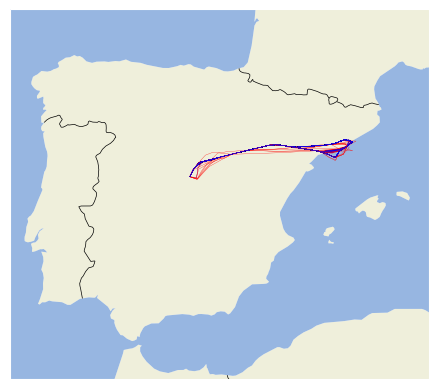

In [19]:
from utils.graphs import show_outliers_map
from sklearn.cluster import DBSCAN

# Run the grid search
best_estimator = search["best_estimator_"]
params = best_estimator["params"]
clusterer = DBSCAN(metric='precomputed', 
                   min_samples=params["min_samples"], 
                   eps=params["eps"])
clusterer.fit(sspd_distances)
labels = clusterer.labels_

show_outliers_map(trajectories, 
                  clusterer.labels_, 
                  f'{GRAPHS_PATH}/outliers_sspd_dbscan.png')

### HDBSCAN

In [20]:
from src.models.search_hdbscan import SearchHDBSCAN

search = SearchHDBSCAN(sspd_distances, params = {
  "min_samples": np.arange(1, 16),
  "min_cluster_size": np.array([2, 5, 10, 20, 40, 60, 80, 100, 120, 140])
}, method=METHOD)

print(pd.DataFrame(search["results_"]).head(20))

                                          params  clusters  outliers   
0    {'min_samples': 1, 'min_cluster_size': 100}         4        18  \
1    {'min_samples': 2, 'min_cluster_size': 100}         4        18   
2    {'min_samples': 3, 'min_cluster_size': 100}         4        18   
3    {'min_samples': 4, 'min_cluster_size': 100}         4        18   
4    {'min_samples': 5, 'min_cluster_size': 100}         4        18   
5    {'min_samples': 6, 'min_cluster_size': 100}         4        18   
6    {'min_samples': 7, 'min_cluster_size': 100}         4        18   
7    {'min_samples': 8, 'min_cluster_size': 100}         4        18   
8    {'min_samples': 9, 'min_cluster_size': 100}         4        18   
9   {'min_samples': 10, 'min_cluster_size': 100}         4        18   
10  {'min_samples': 11, 'min_cluster_size': 100}         4        18   
11  {'min_samples': 12, 'min_cluster_size': 100}         4        18   
12  {'min_samples': 13, 'min_cluster_size': 100}         4      

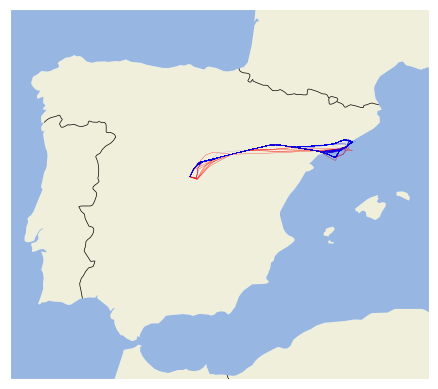

In [21]:
from utils.graphs import show_outliers_map
import hdbscan

params = search["best_estimator_"]["params"]
clusterer = hdbscan.HDBSCAN(metric='precomputed', 
                            min_samples=params["min_samples"], 
                            min_cluster_size =params["min_cluster_size"])
clusterer.fit(sspd_distances)

show_outliers_map(trajectories, clusterer.labels_, f'{GRAPHS_PATH}/outliers_sspd_hdbscan.png')

## ERP Distances

### DBSCAN

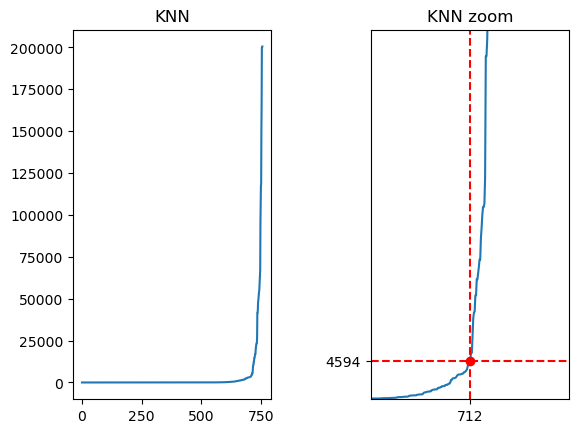

In [22]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
import numpy as np

neighbors = NearestNeighbors(n_neighbors=6, metric='precomputed')
neighbors_fit = neighbors.fit(erp_distances)
distances, indices = neighbors_fit.kneighbors(erp_distances)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

line = np.linspace(distances[0], distances[-1], len(distances))
distances_to_line = np.abs(distances - line)
elbow_index = np.argmax(distances_to_line)

show_elbow_plot(distances, elbow_index, f'{GRAPHS_PATH}/elbow_erp.png')

In [23]:
from src.models.search_dbscan import SearchDBSCAN

search = SearchDBSCAN(erp_distances, params = {
  "eps": np.array([distances[elbow_index]]),
  "min_samples": np.arange(2, 16)
}, method=METHOD)

print(pd.DataFrame(search["results_"]).head(20))

                                           params  clusters  outliers   
0    {'eps': 4594.314241650554, 'min_samples': 3}        14        48  \
1    {'eps': 4594.314241650554, 'min_samples': 2}        16        44   
2    {'eps': 4594.314241650554, 'min_samples': 4}        12        62   
3    {'eps': 4594.314241650554, 'min_samples': 5}        10        70   
4    {'eps': 4594.314241650554, 'min_samples': 6}        10        72   
5    {'eps': 4594.314241650554, 'min_samples': 7}         9        78   
6   {'eps': 4594.314241650554, 'min_samples': 11}         4       124   
7   {'eps': 4594.314241650554, 'min_samples': 12}         4       124   
8   {'eps': 4594.314241650554, 'min_samples': 13}         4       124   
9   {'eps': 4594.314241650554, 'min_samples': 14}         4       124   
10  {'eps': 4594.314241650554, 'min_samples': 15}         4       124   
11  {'eps': 4594.314241650554, 'min_samples': 10}         5       114   
12   {'eps': 4594.314241650554, 'min_samples': 8}  

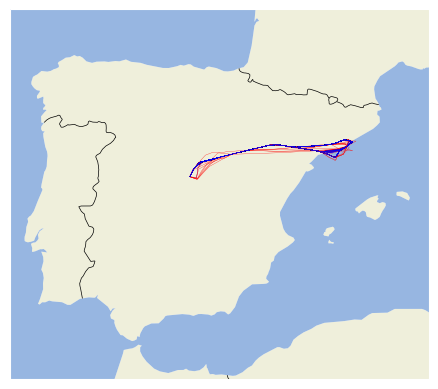

In [24]:
from utils.graphs import show_outliers_map
from sklearn.cluster import DBSCAN

params = search["best_estimator_"]["params"]
clusterer = DBSCAN(metric='precomputed', 
                   min_samples=params["min_samples"], 
                   eps=params["eps"])
clusterer.fit(erp_distances)

show_outliers_map(trajectories, clusterer.labels_, f'{GRAPHS_PATH}/outliers_erp_dbscan.png')

### HDBSCAN

In [25]:
from src.models.search_hdbscan import SearchHDBSCAN

search = SearchHDBSCAN(erp_distances, params = {
  "min_samples": np.arange(1, 16),
  "min_cluster_size": np.array([2, 5, 10, 20, 40, 60, 80, 100, 120, 140])
}, method=METHOD)

print(pd.DataFrame(search["results_"]).head(20))


                                          params  clusters  outliers   
0    {'min_samples': 1, 'min_cluster_size': 100}         4         8  \
1    {'min_samples': 1, 'min_cluster_size': 120}         4         8   
2    {'min_samples': 2, 'min_cluster_size': 100}         4         9   
3    {'min_samples': 2, 'min_cluster_size': 120}         4         9   
4    {'min_samples': 3, 'min_cluster_size': 100}         4         9   
5    {'min_samples': 3, 'min_cluster_size': 120}         4         9   
6    {'min_samples': 4, 'min_cluster_size': 100}         4        11   
7    {'min_samples': 5, 'min_cluster_size': 100}         4        11   
8   {'min_samples': 11, 'min_cluster_size': 100}         4        14   
9   {'min_samples': 12, 'min_cluster_size': 100}         4        14   
10  {'min_samples': 13, 'min_cluster_size': 100}         4        14   
11  {'min_samples': 10, 'min_cluster_size': 100}         4        14   
12   {'min_samples': 9, 'min_cluster_size': 100}         4      

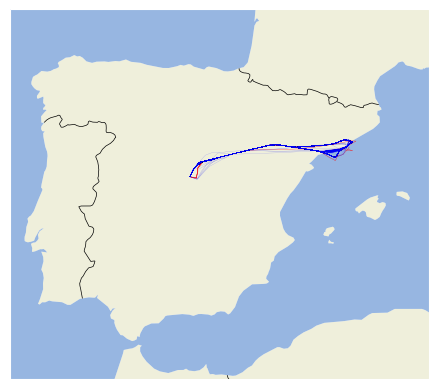

In [26]:
from utils.graphs import show_outliers_map
import hdbscan

params = search["best_estimator_"]["params"]
clusterer = hdbscan.HDBSCAN(metric='precomputed', 
                            min_samples=params["min_samples"], 
                            min_cluster_size =params["min_cluster_size"])
clusterer.fit(erp_distances)

show_outliers_map(trajectories, clusterer.labels_, f'{GRAPHS_PATH}/outliers_erp_hdbscan.png')